
# Project 1: Gravitational Microlensing 

### Geet Purohit, Yoon Kyu Choi, Michael Polanco, George Kharchilava, and Aidan Boyce



## Importing Libraries


In [1]:
import astropy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
import sympy
sympy.init_printing()
import emcee
import corner
plt.rcParams.update({'font.size': 16, 'text.usetex': True})


## Loading the 3 datasets from the OGLE website


In [2]:
dat1 = np.loadtxt('1307.dat', usecols = (0,1,2))
dat2 = np.loadtxt('164.dat', usecols = (0,1,2))
dat3 = np.loadtxt('148.dat', usecols = (0,1,2))

# Assigning the Time, Magnitude, and Magnitude Error Parameters as the first three columns in our datasets

HJD_1, I_1, MagErr_1 = np.hsplit(dat1, 3)
HJD_2, I_2, MagErr_2 = np.hsplit(dat2, 3)
HJD_3, I_3, MagErr_3 = np.hsplit(dat3, 3)


## Defining for each dataset:

    Date of Maximum Brightness (t_0) 
    Blending Ratio (fbl)
    Base Magnitude (m0)
    Min. u at Max. Amp. (umin)
    Event Time Scale (tE) 


In [3]:
#constant definitions

t0_1 = HJD_1[np.where(I_1 == np.min(I_1))]
t0_2 = HJD_2[np.where(I_2 == np.min(I_2))]
t0_3 = HJD_3[np.where(I_3 == np.min(I_3))]

#print(True) if (HJD_1[np.where(I_1 == np.min(I_1))] == t0_1) else print(False) #works fine


#all these subsequent values are taken from the OGLE website

fbl_1 = 0.885
fbl_2 = 1.00
fbl_3 = 1.00 

m0_1 = 16.811
m0_2 = 18.814
m0_3 = 13.403

umin_1 = 0.047
umin_2 = 0.118
umin_3 = 0.279

tE_1 = 23.127
tE_2 = 6.236
tE_3 = 58.205



## Defining the Model and Chisq Functions


In [4]:

def model(t, m0, fbl, t0, tE, umin):
    u = np.sqrt((umin**2) + ((t - t0)/tE)**2)
    A = (u**2 + 2) / (u*np.sqrt(u**2 + 4))
    return m0 - 2.5*np.log10(fbl*A + (1 - fbl))

def chisq(param, x, y, sigma):
    tpeak, fbl, m0, umin, tau = param
    return np.sum(((model(x, m0, fbl, tpeak, tau, umin) - y)**2)/sigma**2)

#remember to link resource for presentation + paper

def lnlike(param, x, y, sigma):
    return -0.5*chisq(param, x, y, sigma)

def lnprior(param):
    tpeak, fbl, m0, umin, tau = param
    if 0 < fbl < 1:
        return 0.0
    return -np.inf

def lnprob(param, x, y, sigma):
    lp = lnprior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(param, x, y, sigma)


## Defining the MCMC Function


In [5]:
def mcmc(par):
    pstart = par
    p0 = np.array([pstart+1.0e-4*np.random.normal(size=ndim) for iwalk in range(nwalk)])
    sampler = emcee.EnsembleSampler(nwalk,ndim,lnprob, args=(x, y, sigma))
    print('burn-in-run')
    pos, prob, state = sampler.run_mcmc(p0,nburn)
    sampler.reset()
    print('main-run')
    res = sampler.run_mcmc(pos,nmain)
    samples = sampler.chain.reshape((-1,ndim))
    return samples, sampler 


## Defining the MCMC Plot Function


In [6]:
def mcmc_plotter(sampler):
    labels = [r'$t_{0}$',r'$f_{bl}$',r'$m_{src}$', r'$u_{min}$', r'$t_{E}$']
    f,ax = plt.subplots(ndim,1,figsize=(10,10))
    for idim in range(ndim):
        for iwalk in range(nwalk):
            ax[idim].plot(sampler.chain[iwalk,:,idim])
        ax[idim].set_xlabel('step')
        ax[idim].set_ylabel(labels[idim])
    f.tight_layout()



# Dataset 1: OGLE 1307 




## Plotting the Model Function and Residuals Plot


Text(0, 0.5, 'Error Value"')

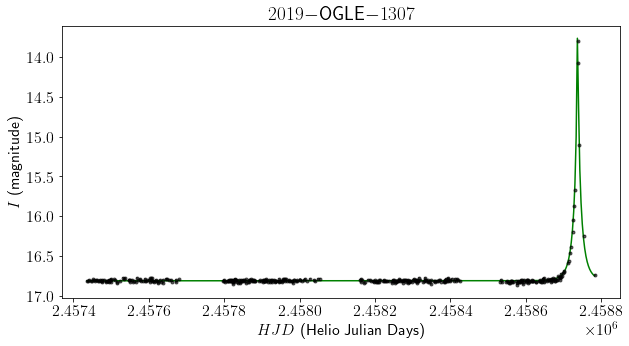

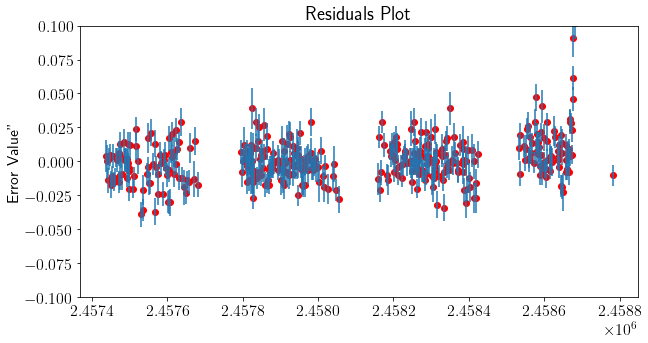

In [50]:
t = np.linspace(np.min(HJD_1), np.max(HJD_1), HJD_1.size)

plt.figure(figsize = (10,5))
#have to flattern yerr, otherwise throws dim error
plt.errorbar(HJD_1, I_1, yerr = MagErr_1.flatten(), fmt = '.', color='black', ecolor='black', alpha=0.6)
plt.plot(t, model(t, m0_1, fbl_1, t0_1, tE_1, umin_1), color='green')
#plt.invert_yaxis() #doesn't work
plt.ylim(plt.ylim()[::-1]) #inverts y axis
plt.xlabel(r'$HJD$ (Helio Julian Days)')
plt.ylabel(r'$I$ (magnitude)')
plt.title(r'$2019 - $OGLE$ - 1307$')
plt.savefig('2019-BLG-1307_Original_Data.png', dpi=150)


plt.figure(figsize = (10,5))
residual = (I_1[:,0] - model(t, m0_1, fbl_1, t0_1, tE_1, umin_1))
plt.scatter(HJD_1, residual, color = 'r')
plt.errorbar(HJD_1, residual, yerr = MagErr_1[:,0], ls = 'none')
plt.ylim(-0.1, 0.1)
plt.title('Residuals Plot')
plt.ylabel('Error Value"')



## Defining the Parameters for the mcmc Function


In [8]:

x, y, sigma, nwalk, nburn, nmain, ndim, plab= HJD_1, I_1, MagErr_1,20, 400, 2000, 5, [r'$t_{0}$',r'$f_{bl}$',r'$m_{src}$', r'$u_{min}$', r'$t_{E}$']
par_1 = np.array([t0_1, fbl_1, m0_1, umin_1, tE_1], dtype=float) #init guesses for data1


<ipython-input-8-c999ca6b1a6c>:2: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  par_1 = np.array([t0_1, fbl_1, m0_1, umin_1, tE_1], dtype=float) #init guesses for data1



## Plotting the Walkers and Generating the Corner Plot


burn-in-run
main-run


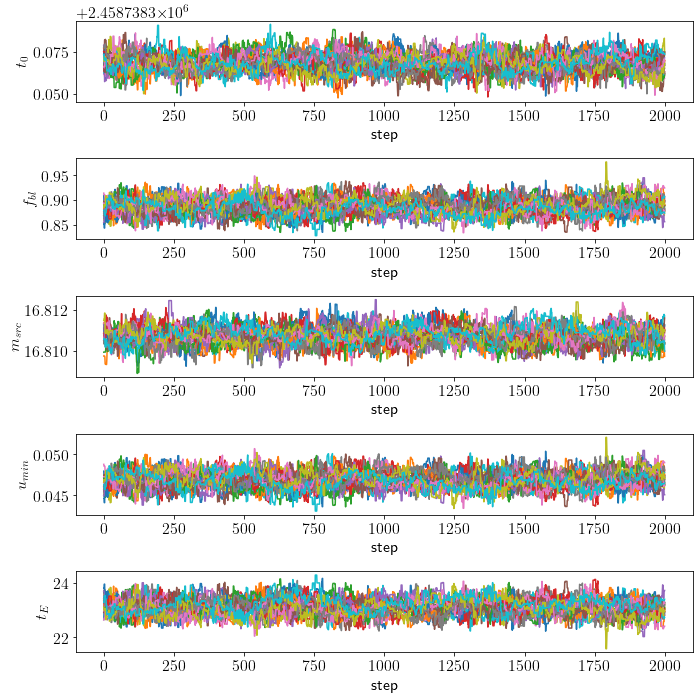

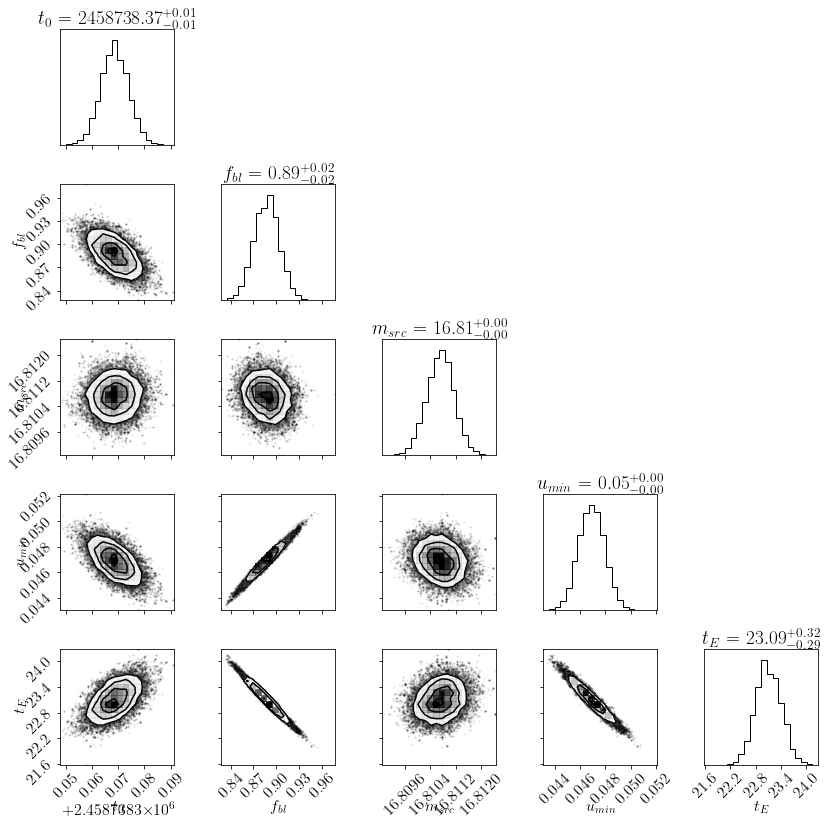

In [9]:

samples1, sampler1 = mcmc(par_1)
mcmc_plotter(sampler1)
f = corner.corner(samples1,show_titles=True,labels=plab)
f.tight_layout()



# Dataset 2: OGLE 0164




## Plotting the Model Function and Residuals Plot


Text(0, 0.5, 'Error Value"')

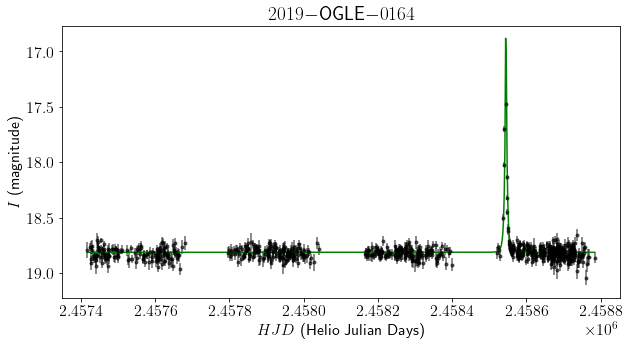

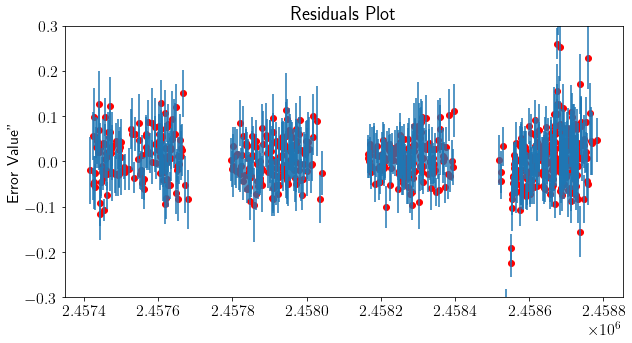

In [53]:
t = np.linspace(np.min(HJD_2), np.max(HJD_2), HJD_2.size)
plt.figure(figsize = (10,5))
#have to flattern yerr, otherwise throws dim error
plt.errorbar(HJD_2, I_2, yerr = MagErr_2.flatten(), fmt = '.', color='black', ecolor='black', alpha=0.6)
plt.plot(t, model(t, m0_2, fbl_2, t0_2, tE_2, umin_2), color='green')
#plt.invert_yaxis() #doesn't work
plt.ylim(plt.ylim()[::-1]) #inverts y axis
plt.xlabel(r'$HJD$ (Helio Julian Days)')
plt.ylabel(r'$I$ (magnitude)')
plt.title(r'$2019 - $OGLE$ - 0164$')
plt.savefig('2019-BLG-0164_Original_Data.png', dpi=150)


plt.figure(figsize = (10,5))
residual = (I_2[:,0] - model(t, m0_2, fbl_2, t0_2, tE_2, umin_2))
plt.scatter(HJD_2, residual, color = 'r')
plt.errorbar(HJD_2, residual, yerr = MagErr_2[:,0], ls = 'none')
plt.ylim(-0.3, 0.3)
plt.title('Residuals Plot')
plt.ylabel('Error Value"')


## Defining the Parameters for the mcmc Function


In [11]:

x, y, sigma, nwalk, nburn, nmain, ndim, plab= HJD_2, I_2, MagErr_2,20, 400, 2000, 5, [r'$t_{0}$',r'$f_{bl}$',r'$m_{src}$', r'$u_{min}$', r'$t_{E}$']
par_2 = np.array([t0_2, fbl_2, m0_2, umin_2, tE_2], dtype=float) #init guesses for data1


<ipython-input-11-9f037116ad90>:2: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  par_2 = np.array([t0_2, fbl_2, m0_2, umin_2, tE_2], dtype=float) #init guesses for data1



## Plot the walkers and generate the corner plot


C:\Users\mikep\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


burn-in-run
main-run


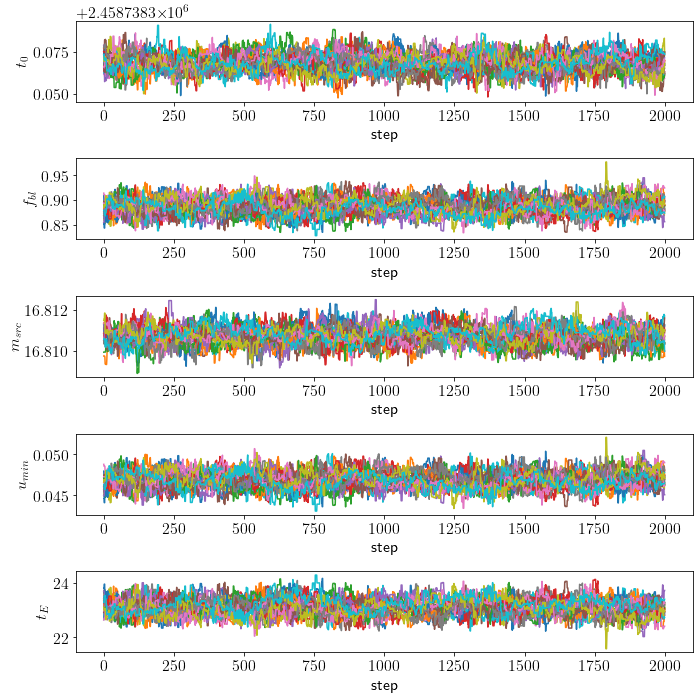

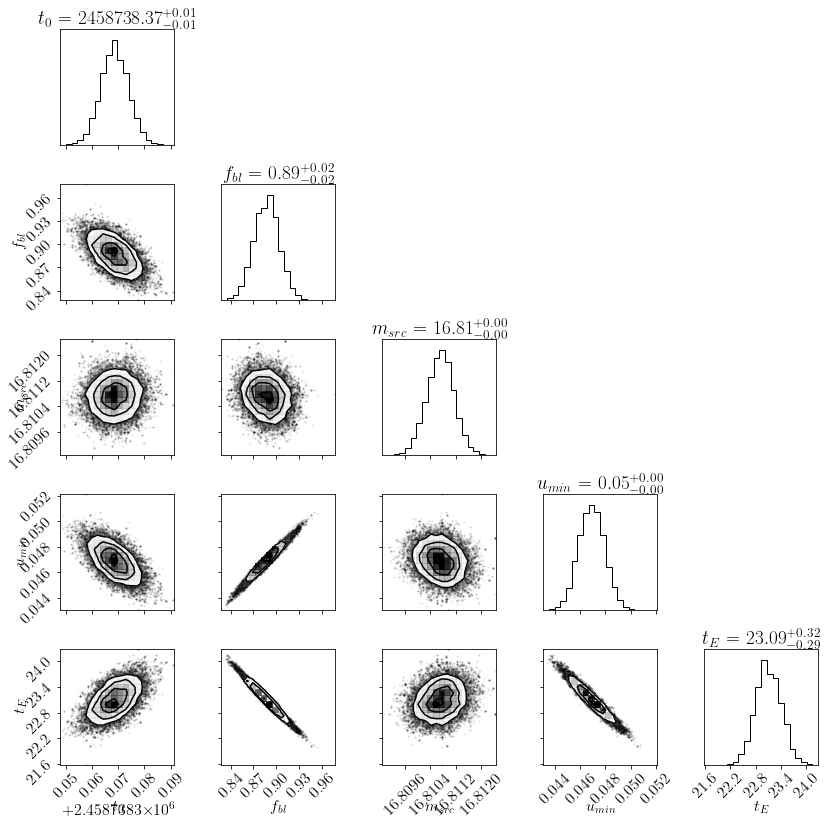

In [12]:

samples2, sampler2 = mcmc(par_2)
mcmc_plotter(sampler1)
f = corner.corner(samples1,show_titles=True,labels=plab)
f.tight_layout()



# Dataset 3: OGLE 0148




## Plotting the Model Function and Residuals Plot


Text(0, 0.5, 'Error Value"')

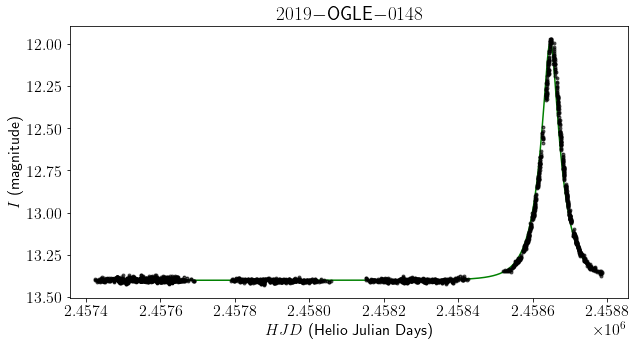

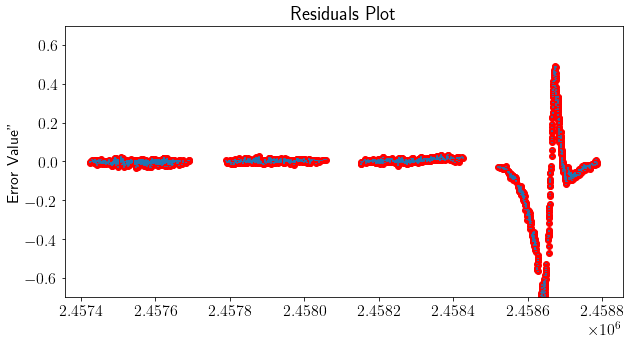

In [56]:
t = np.linspace(np.min(HJD_3), np.max(HJD_3), HJD_3.size)
plt.figure(figsize = (10,5))
#have to flattern yerr, otherwise throws dim error
plt.errorbar(HJD_3, I_3, yerr = MagErr_3.flatten(), fmt = '.', color='black', ecolor='black', alpha=0.6)
plt.plot(t, model(t, m0_3, fbl_3, t0_3, tE_3, umin_3), color='green')
#plt.invert_yaxis() #doesn't work
plt.ylim(plt.ylim()[::-1]) #inverts y axis
plt.xlabel(r'$HJD$ (Helio Julian Days)')
plt.ylabel(r'$I$ (magnitude)')
plt.title(r'$2019 - $OGLE$ - 0148$')
plt.savefig('2019-BLG-0148_Original_Data.png', dpi=150)


plt.figure(figsize = (10,5))
residual = (I_3[:,0] - model(t, m0_3, fbl_3, t0_3, tE_3, umin_3))
plt.scatter(HJD_3, residual, color = 'r')
plt.errorbar(HJD_3, residual, yerr = MagErr_3[:,0], ls = 'none')
plt.ylim(-0.7, 0.7)
plt.title('Residuals Plot')
plt.ylabel('Error Value"')




## Defining the Parameters for the mcmc Function


In [59]:

x, y, sigma, nwalk, nburn, nmain, ndim, plab= HJD_3, I_3, MagErr_3,20, 400, 2000, 5, [r'$t_{0}$',r'$f_{bl}$',r'$m_{src}$', r'$u_{min}$', r'$t_{E}$']
par_3 = np.array([t0_3, fbl_3, m0_3, umin_3, tE_3], dtype=float) #init guesses for data1


<ipython-input-59-4c77f4b87bfe>:2: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  par_3 = np.array([t0_3, fbl_3, m0_3, umin_3, tE_3], dtype=float) #init guesses for data1



## Plot the walkers and generate the corner plot


burn-in-run


C:\Users\mikep\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


main-run


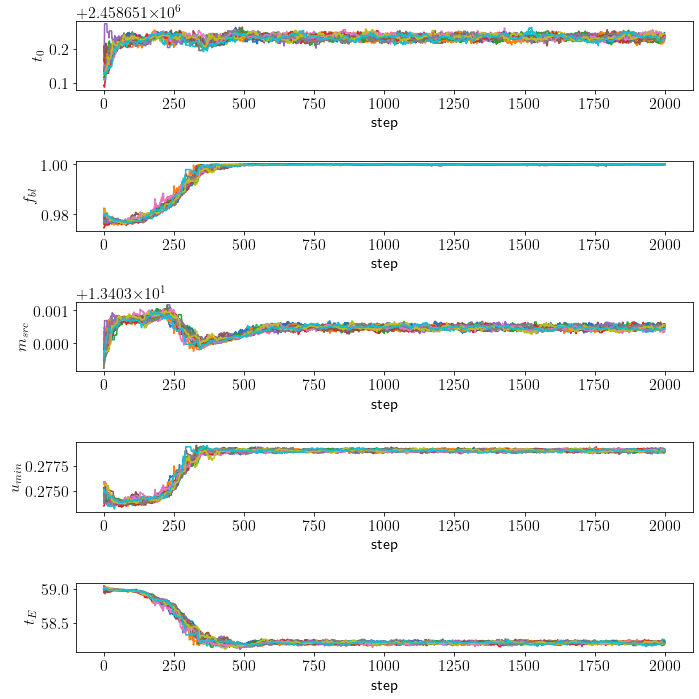

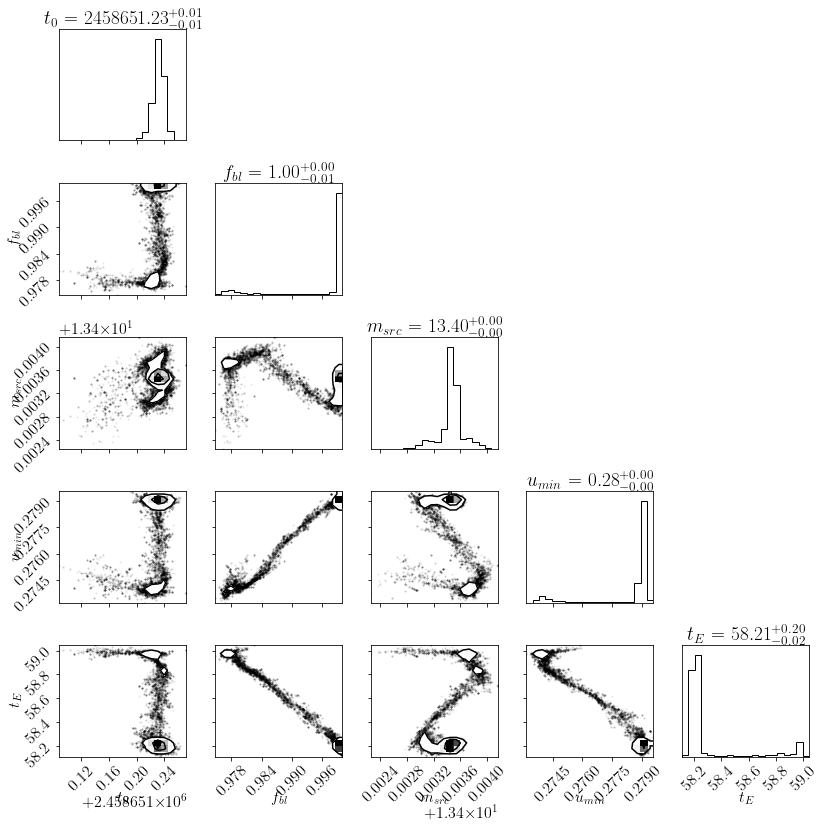

In [58]:
# Plot the walkers and generate the corner plot
samples3, sampler3 = mcmc(par_3)
mcmc_plotter(sampler3)
f = corner.corner(samples3,show_titles=True,labels=plab)
f.tight_layout()